#### Baseline Forecast

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
from datetime import datetime, timedelta, date, time
import calendar
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
color_pal = sns.color_palette()

#### Set parameters

In [2]:
# Set Parameters for Model Training and Evaluation
quantiles = [0.025, 0.25, 0.5, 0.75, 0.975]
train_data_end = "2025-01-01"

periods = 4
test_start = "2024-02-22"
test_end = "2025-02-19"


# Switch features on or off
time_based_features = 2         # 0 for no time based features, 1 for dummy variables, 2 for categorical variables
lag_1week = 1                   # 0 for no lag features, 1 for lag features

# Set Parameters for final prediction 
train_data_end = "2025-01-01"
forecast_horizon = 168          #hours
hours=3                         # gap between current time and end of training data in hours

#### Load Data

In [3]:
df = pd.read_csv('../data/combined_data/combined_energy_data.csv', parse_dates=["Datetime"], index_col="Datetime")

# define time zone as ezrope/berlin to account for time shifts in original data
df.index = pd.to_datetime(df.index, utc=True).tz_convert('Europe/Berlin')

# convert back to utc to remove time shifts
df.index = df.index.tz_convert('UTC')

# remove tz awareness
df.index = df.index.tz_localize(None)

#### Rolling Window and Model

In [ ]:
data = df[["target"]].copy()
data['hour'] = data.index.hour
data['dayofweek'] = data.index.dayofweek

test_data = data.loc[test_start:test_end]

results = []

for timestamp in test_data.index:

    current_hour = timestamp.hour
    current_dayofweek = timestamp.dayofweek

    historical_data = data[
        (data.index < timestamp) & 
        (data['hour'] == current_hour) & 
        (data['dayofweek'] == current_dayofweek)

    if len(historical_data) < periods:
        continue
        
    historical_values = historical_data['target'].tail(periods).values

    quantile_forecast = np.quantile(historical_values, quantiles)

    results.append({
        "index": timestamp,
        "target": test_data.loc[timestamp, "target"],
        **{f"q{q}": qf for q, qf in zip(quantiles, quantile_forecast)}
    })

results = pd.DataFrame(results).set_index("index")
results.index.name = "Datetime"

In [9]:
import os
folder = "results"
os.makedirs(folder, exist_ok=True)
results.to_csv(f"{folder}/Baseline Forecast.csv", index=True)
results

,target,q0.025,q0.25,q0.5,q0.75,q0.975
Datetime,,,,,,
2024-02-22 00:00:00,48.25425,45.891950,47.914250,48.830750,49.563063,51.088056
2024-02-22 01:00:00,47.45925,45.583331,47.120812,48.191875,48.994312,49.806506
2024-02-22 02:00:00,47.70125,46.068556,47.520313,48.735000,49.622062,50.189231
2024-02-22 03:00:00,48.74600,47.566400,48.992000,50.252500,51.160688,51.635044
2024-02-22 04:00:00,51.82350,50.764231,52.654063,53.542125,54.063375,54.962812
...,...,...,...,...,...,...
2025-02-19 19:00:00,67.27350,63.700275,64.528500,64.901625,65.369687,66.454244
2025-02-19 20:00:00,63.54225,60.397287,61.025375,61.340000,61.678000,62.369200
2025-02-19 21:00:00,60.85075,57.163313,57.505875,58.126500,58.733250,59.038350


<AxesSubplot:title={'center':'Baseline Forecast'}, xlabel='Datetime'>

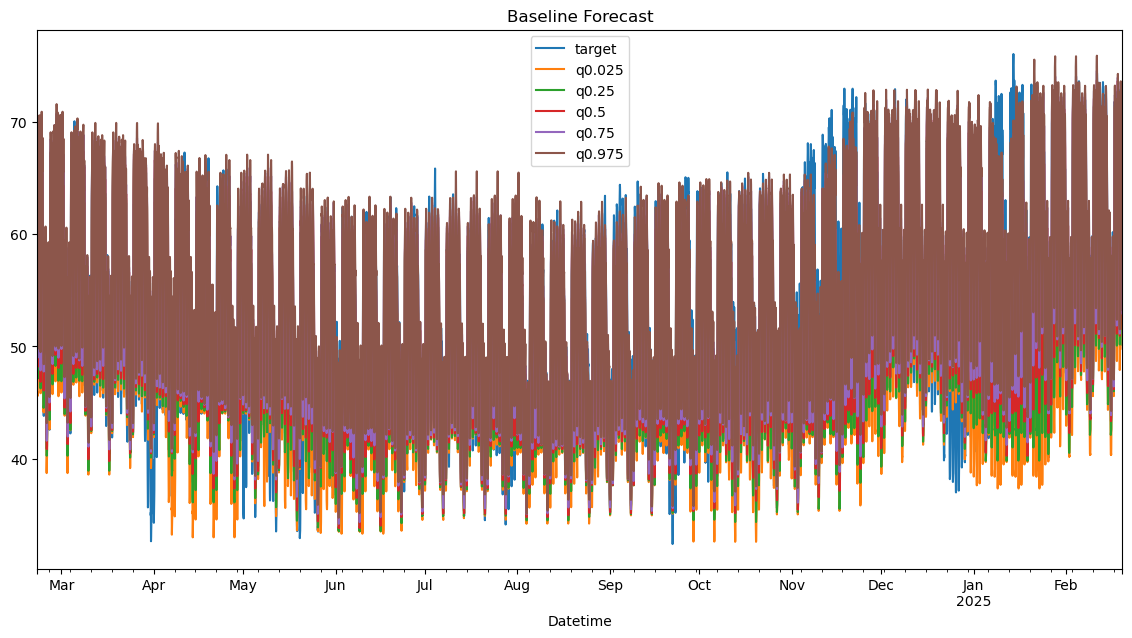

In [10]:
results.plot(y=["target","q0.025", "q0.25", "q0.5", "q0.75", "q0.975"], figsize=(14, 7), title="Baseline Forecast")

#### Evaluation

In [11]:
# Quantile Loss für jedes Quantil berechnen
quantile_losses = {}

for q in quantiles:
    # Vorhersage und tatsächliche Werte extrahieren
    y_pred = results[f'q{q}']
    y_true = results['target']
    
    # Quantile Loss für jedes Quantil berechnen
    quantile_loss = np.where(y_pred > y_true, 
                             2 * (1 - q) * (y_pred - y_true), 
                             2 * q * (y_true - y_pred))
    
    # Durchschnittlicher Quantile Loss über alle Zeitpunkte
    quantile_losses[f'Quantile_{q}'] = quantile_loss.mean()

# Summiere alle Quantile Scores zu einem Gesamtscore
total_loss_score = sum(quantile_losses.values())

# Ergebnisse anzeigen
print("Durchschnittlicher Quantile Loss für jedes Quantil:")
for quantile, loss in quantile_losses.items():
    print(f"{quantile}: {loss}")

print(f"\nGesamtscore über alle Quantile: {total_loss_score}")

Durchschnittlicher Quantile Loss für jedes Quantil:
Quantile_0.025: 1.4445490323803798
Quantile_0.25: 2.4500716932806776
Quantile_0.5: 2.5911114640567767
Quantile_0.75: 1.9841368546817766
Quantile_0.975: 0.8574186643629811

Gesamtscore über alle Quantile: 9.327287708762592


In [12]:
results['hour'] = results.index.hour
results['dayofweek'] = results.index.dayofweek

horizons_dict = {}

# Target-Horizons mit den entsprechenden Stundenbezeichnungen
target_horizons = [
    {"dayofweek": 4, "hour": 12, "name": "36"},  # Freitag 12:00 Stunde: 36
    {"dayofweek": 4, "hour": 16, "name": "40"},  # Freitag 16:00 Stunde: 40
    {"dayofweek": 4, "hour": 20, "name": "44"},  # Freitag 20:00 Stunde: 44
    {"dayofweek": 5, "hour": 12, "name": "60"},  # Samstag 12:00 Stunde: 60
    {"dayofweek": 5, "hour": 16, "name": "64"},  # Samstag 16:00 Stunde: 64
    {"dayofweek": 5, "hour": 20, "name": "68"},  # Samstag 20:00 Stunde: 68
]

for horizon in target_horizons:
    # Daten für den aktuellen Zeithorizont filtern
    horizon_data = results[(results["dayofweek"] == horizon["dayofweek"]) & (results["hour"] == horizon["hour"])]
    horizon_data = horizon_data.drop(columns=["hour", "dayofweek"])

    # DataFrame unter dem angegebenen Namen speichern
    horizons_dict[horizon["name"]] = horizon_data

In [13]:
# Funktion zur Berechnung der Quantile Losses
def calculate_quantile_losses(horizons_dict, quantiles):
    all_quantile_losses = {}
    
    for key, df in horizons_dict.items():
        quantile_losses = {}
        for q in quantiles:
            y_pred = df[f'q{q}']
            y_true = df['target']
            quantile_loss = np.where(y_pred > y_true, 2 * (1 - q) * (y_pred - y_true), 2 * q * (y_true - y_pred))
            quantile_losses[f'q{q}'] = quantile_loss.mean()
        
        # Gesamtscore (Summe der quantilen Verluste)
        total_loss_score = sum(quantile_losses.values())
        quantile_losses['Total_Loss_Score'] = total_loss_score
        all_quantile_losses[key] = quantile_losses
    
    return all_quantile_losses

# Berechnung der Quantile Losses
quantile_loss_results = calculate_quantile_losses(horizons_dict, quantiles)

# Ergebnisse anzeigen
horizon_results_df = pd.DataFrame(quantile_loss_results).T
horizon_results_df

,q0.025,q0.25,q0.5,q0.75,q0.975,Total_Loss_Score
36,1.915355,2.913164,3.094221,2.368843,0.929510,11.221092
40,1.634927,2.585657,2.906923,2.452859,1.103168,10.683534
44,1.110674,1.986558,2.252151,1.917724,0.950565,8.217673
60,0.970392,1.839054,2.002252,1.750723,0.901845,7.464266
64,0.932459,1.767199,2.070873,1.718641,0.872676,7.361846
68,0.710322,1.523338,1.835130,1.554917,0.723680,6.347387


#### Final Evaluation Score

In [14]:
horizon_results_df.sum()

q0.025               7.274128
q0.25               12.614971
q0.5                14.161550
q0.75               11.763707
q0.975               5.481443
Total_Loss_Score    51.295798
dtype: float64